# Statistical Analyses of Fake Job Postings Dataset

## Summary

In this notebook, we build models based on two sets of features in order to predict whether a job posting is fraudulent or not.

### 1. Numeric Features

**1.1. Column Selection**<br>
First, we select numeric columns to train a model to classify the job listings, such as character length of the individual text passages. These columns also include dichotomous variables, depicting the existance of certain characteristics of a job posting. For example: is a salary range stated, is there a company logo displayed, as well as previously created dummies for the individual labels present in education, experience, employment type, and country.

**1.2. Cross Validation**<br>
After having specified our included features, cross-validation is utilized for model selection. The algorithms included were tree based, e.g. Decision Tree, Random Forest, Gradient Boosting, XGBoost, and LightGBM. On the other hand, some models were not considered due to incapability of dealing with missing data, as it was decided to keep NaNs due to issues involved (i.e.  removal would have resulted in very few cases; imputation might be meaningless) as well as the nature and meaning of their presence in this particular research (i.e. not having stated certain info in a job posting could speak for itself). Models not considered were e.g. Logistic Regression, Naive Bayes, and Support Vector Machines.

**1.3. Training XGBoost**<br>
The cross-validation suggested XGBoost as the model best capable of describing our data. As we are dealing with class-imbalance (only ~5% of our sample are in class 1, i.e. fraudulent jobs) the decision was based on the F1-score. The final performance of the model is promising: Accuracy=0.98, Recall=0.64, Precision=0.84, F1-Score=0.73, ROC-AUC=0.98, PR-AUC=0.81.

**1.4. Feature Importance**<br>
Investigating feature importance as well as Shapley Values has shown that the lengths of individual text passages are amongst the most important features in our model. Furthermore, the fact that job postings display a/the company logo also adds substantially to the explanatory power of the model.

### 2. Written Job Description, TF-IDF Vectorized

**2.1. TF-IDF Vectorization**<br>
The first step was to vectorize the terms of each written job description - comprising all 4 written parts present in the dataset: company profile, description, requirements, benefits. It was chosen not to transform the terms to lowercase in order to maintain abbreviations such as 'IT' and company names. Stopwords from the English language however were excluded.

**2.2. Cross Validation**<br>
This time, we aimed at predicting fraudulent jobs via the TF-IDF vector. Since we did not have missing values in this case, the list of algorithms was extended by e.g. Logistic Regression, SVC, k-NN, and Naive Bayes. HistBoost and CatBoost on the other hand were excluded due to data format (i.e. sparse matrix) and performance issues.
The cross-validation process took around 25 Minutes to compute, the results were therefore stored as a pickle file to access again without having to re-run the cross-validation.
The result, again paying attention to the F1-Score, was that the Linear Support Vector Classifier performed best in predicting fraudulent jobs. 

**2.3. Training LinearSVC**<br>
Re-training our model we cot satisfactory results for the model's performance: Accuracy=0.98, Recall=0.68, Precision=0.99, F1-Score=0.81

**2.4. Feature Importance**<br>
Feature Importance and Shapley Values are not directly applicable to SVCs. Therefore, we simply looked at the coefficients size and sign. We picked out the top 30 positive and top 30 negative features to interpret. These draw a relatively clear picture. Amongst the features with positive coefficients, and thus pulling the classification towards class 1 = fraudulent jobs, we find certain company names that are associated with fraudulent jobs. Furthermore, terms such as 'wages', 'Money' and 'earn' show the monetary focus these postings have, while words such as 'Entry' and 'duties' propose fraudulent jobs being frequently tailored to more inexperienced applicants.
On the other side, amongst features with negative coefficients suggesting being closer associated with real jobs, we find positive and encouraging words such as 'fun', 'positive', 'comfortable', 'passionate'. Finally, we find more terms describing the working environment, like 'agency', 'client(s)', 'team', and 'startup'.

In [1]:
# import libraries
import pickle
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap

from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.metrics import (accuracy_score, average_precision_score, 
                             balanced_accuracy_score, jaccard_score, f1_score, 
                             recall_score, roc_auc_score, precision_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [2]:
# import data and have a peek at the first 3 rows
df = pd.read_csv('C:/Users/nickm/Desktop/Coding/Projects/fake-job-postings/fake_job_postings_CLEANED_RECODED.gzip', compression='gzip')
df.head(3)

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_education_Associate Degree,required_education_Bachelor's Degree,required_education_Doctorate,required_education_High School or equivalent,required_education_Master's Degree,required_education_Some College Coursework Completed,required_education_Some High School Coursework,required_education_Unspecified,required_education_Prof_Voca_Cert,required_education_short
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Predicting Fraudulent Jobs Based on Numeric Features

### Feature Inspection and Column Selection

In [3]:
# Define columns to inspect and display descriptive statistics
num_cols = df.dtypes[df.dtypes != 'object'].index.to_list()

df[num_cols].astype(float).describe().T

,count,mean,std,min,25%,50%,75%,max
job_id,17598.0,8898.866746,5166.312506,1.000000,4422.25,8861.5,13373.75,17880.0
telecommuting,17598.0,0.042846,0.202515,0.000000,0.00,0.0,0.00,1.0
has_company_logo,17598.0,0.794181,0.404310,0.000000,1.00,1.0,1.00,1.0
has_questions,17598.0,0.492045,0.499951,0.000000,0.00,0.0,1.00,1.0
fraudulent,17598.0,0.048585,0.215005,0.000000,0.00,0.0,0.00,1.0
has_company_profile,17598.0,0.813558,0.389474,0.000000,1.00,1.0,1.00,1.0
has_description,17598.0,1.000000,0.000000,1.000000,1.00,1.0,1.00,1.0
has_requirements,17598.0,0.849528,0.357543,0.000000,1.00,1.0,1.00,1.0
has_benefits,17598.0,0.596147,0.490683,0.000000,0.00,1.0,1.00,1.0
company_profile_length,14317.0,761.595656,536.958467,9.000000,391.00,684.0,1022.00,6178.0


### Feature Correlation

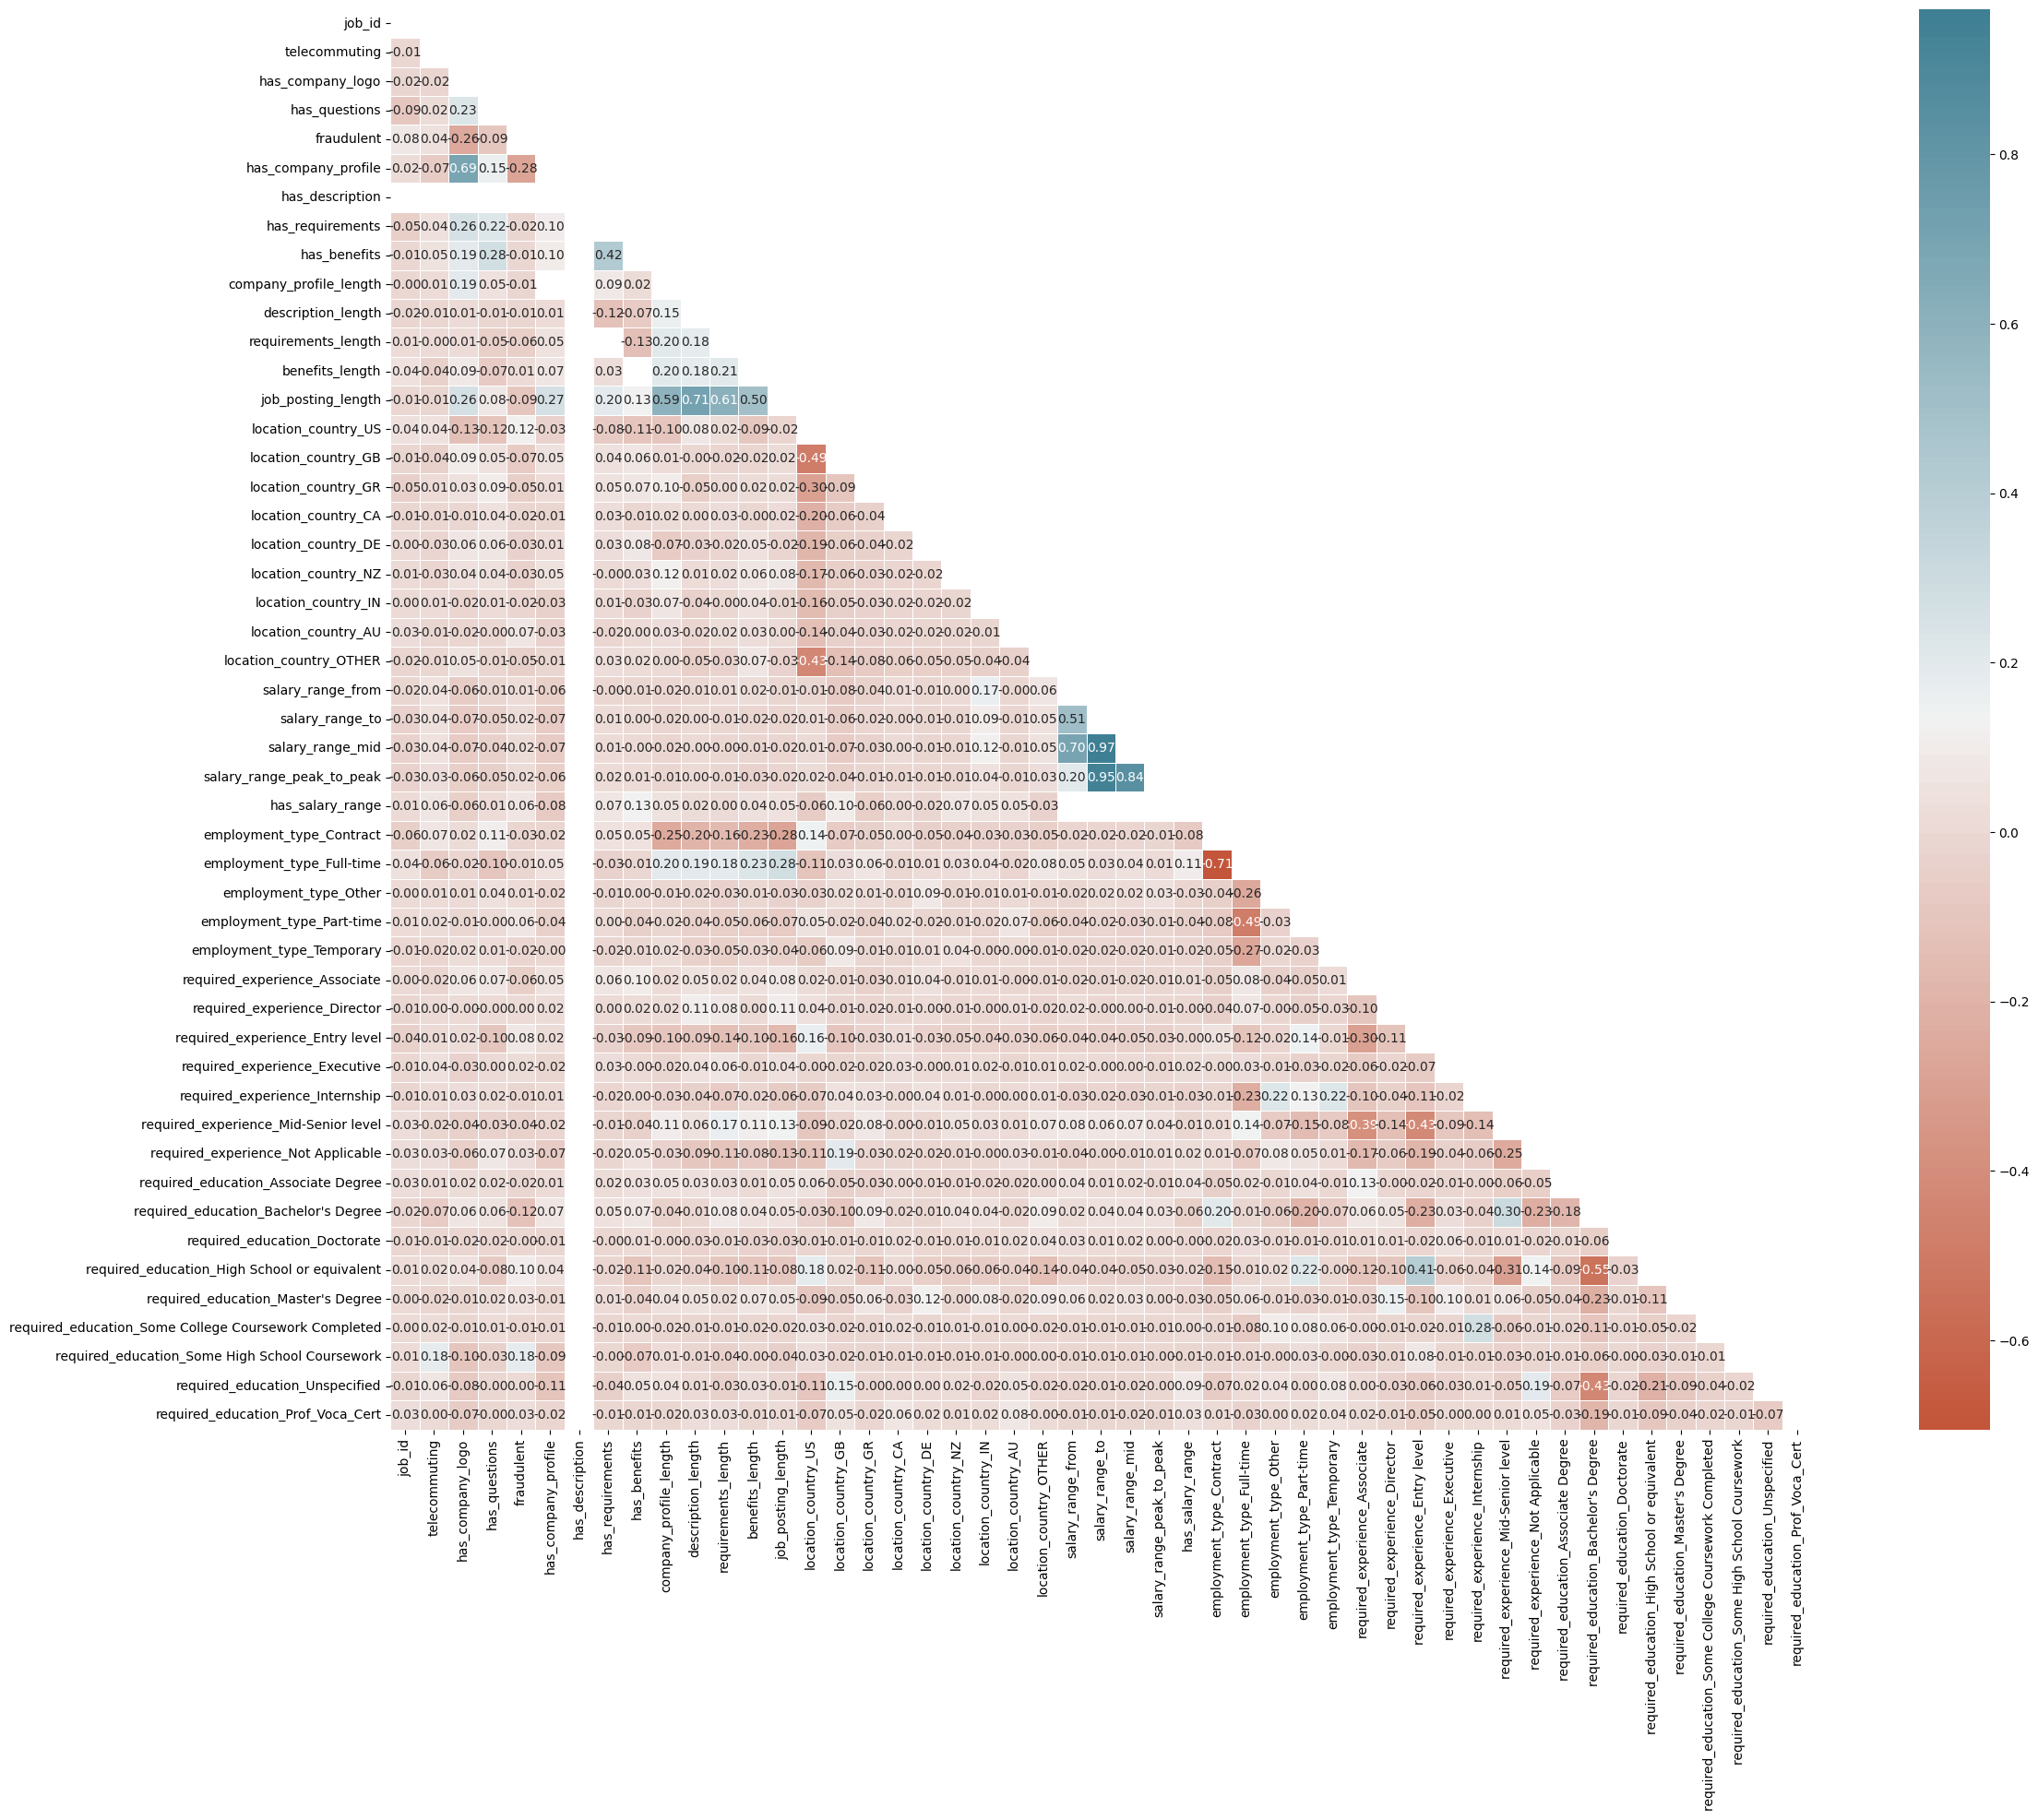

In [4]:
correlations = df[num_cols].corr()

plt.figure(figsize=(30,20))
sns.heatmap(correlations,
            mask=np.triu(correlations),
            square=True,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(20, 220, n=200));

### Jaccard Similarities for Dichotomous Features

In [5]:
# Build jaccard function with sklearn.jaccard_score
def jaccard_matrix(data):
    cols = data.columns
    n_cols = len(cols)
    results = np.empty((n_cols,n_cols)) * np.nan

    for result_row, y_col in enumerate(cols):
        for result_col, x_col in enumerate(cols):
            # to only populate lower diagonal part of result matrix, skip to next iteration when x == y
            if result_row == result_col:
                break
            # exclude missings pairwise
            temp_df = df[[y_col, x_col]].dropna()
            
            results[result_row][result_col] = jaccard_score(temp_df[y_col], temp_df[x_col])
    
    return pd.DataFrame(results, index=cols, columns=cols)

In [6]:
df.columns

Index(['job_id', 'title', 'location', 'department', 'salary_range',
       'company_profile', 'description', 'requirements', 'benefits',
       'telecommuting', 'has_company_logo', 'has_questions', 'employment_type',
       'required_experience', 'required_education', 'industry', 'function',
       'fraudulent', 'has_company_profile', 'has_description',
       'has_requirements', 'has_benefits', 'job_posting',
       'company_profile_length', 'description_length', 'requirements_length',
       'benefits_length', 'job_posting_length', 'location_country',
       'location_state', 'location_city', 'location_country_US',
       'location_country_GB', 'location_country_GR', 'location_country_CA',
       'location_country_DE', 'location_country_NZ', 'location_country_IN',
       'location_country_AU', 'location_country_OTHER',
       'location_country_short', 'salary_range_from', 'salary_range_to',
       'salary_range_mid', 'salary_range_peak_to_peak', 'has_salary_range',
       'employment

In [7]:
# Select only dichotomous columns
not_bool_cols = ['job_id', 'company_profile_length', 'description_length', 
                 'requirements_length', 'benefits_length', 'job_posting_length',
                 'salary_range_from', 'salary_range_to', 'salary_range_mid', 'salary_range_peak_to_peak']
bool_cols = [col for col in num_cols if col not in not_bool_cols]
bool_cols[:5]

['telecommuting',
 'has_company_logo',
 'has_questions',
 'fraudulent',
 'has_company_profile']

In [8]:
# Compute jaccard_similarities
jaccard_similarities = jaccard_matrix(df[bool_cols])
jaccard_similarities.iloc[:5,:4].round(4)

,telecommuting,has_company_logo,has_questions,fraudulent
telecommuting,NaN,NaN,NaN,NaN
has_company_logo,0.0401,NaN,NaN,NaN
has_questions,0.0450,0.5164,NaN,NaN
fraudulent,0.0414,0.0194,0.0269,NaN
has_company_profile,0.0357,0.8865,0.4916,0.0185


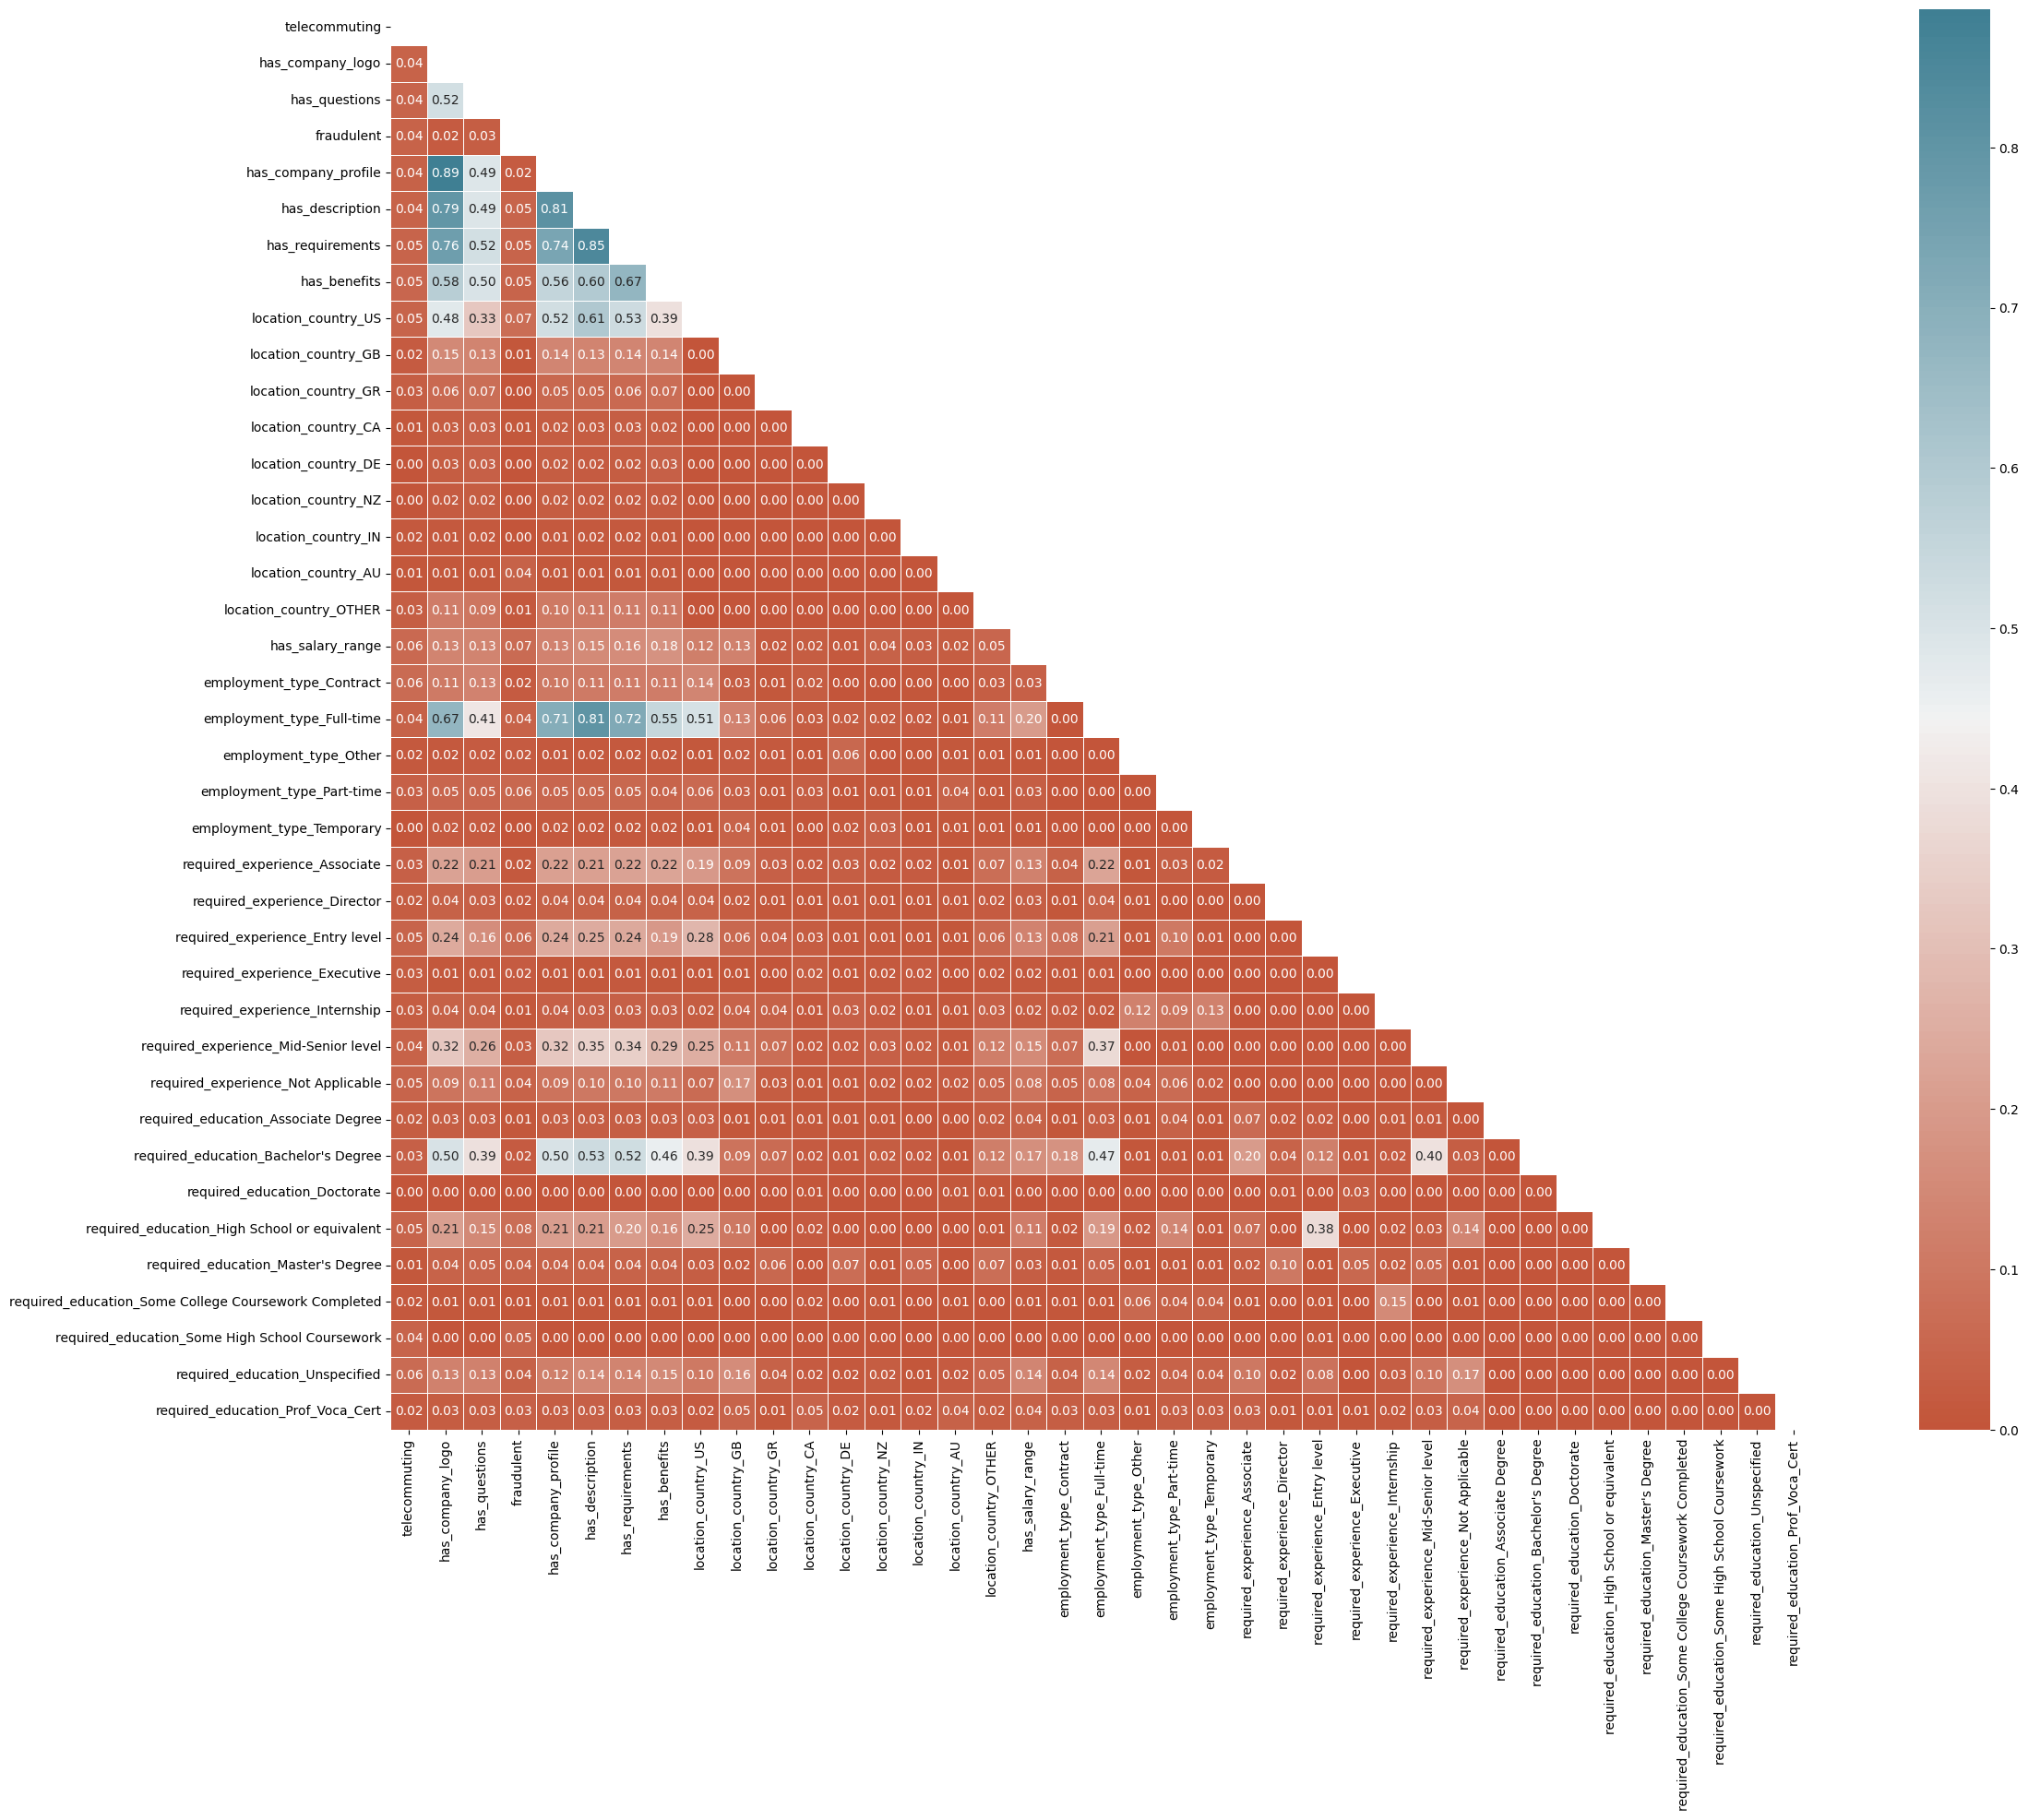

In [9]:
# plot jaccard scores
plt.figure(figsize=(30,20))
sns.heatmap(jaccard_similarities,
            square=True,
            annot=True,
            fmt='.2f',
            linewidths=0.5,
            cmap=sns.diverging_palette(20, 220, n=200));

### Missings

In [10]:
# print number of missings per column
df[num_cols].isna().sum()

job_id                                                      0
telecommuting                                               0
has_company_logo                                            0
has_questions                                               0
fraudulent                                                  0
has_company_profile                                         0
has_description                                             0
has_requirements                                            0
has_benefits                                                0
company_profile_length                                   3281
description_length                                          0
requirements_length                                      2648
benefits_length                                          7107
job_posting_length                                          0
location_country_US                                       341
location_country_GB                                       341
location

### Remove Unused Columns

In [11]:
# Exclude certain columns from the analysis
excluded_columns = []

# job_id
excluded_columns.append('job_id')

# 'has_description' is a constant - every job in our dataset has a description
excluded_columns.append('has_description')

# Salary ranges - too many missings and uncertainty regarding proper format (yearly, monthly, k,...)
excluded_columns.extend(['salary_range_from', 'salary_range_to', 'salary_range_mid', 'salary_range_peak_to_peak'])

# Text passage presence dummies - perfectly correlated with passage length
excluded_columns.extend(['has_company_profile', 'has_requirements', 'has_benefits',])

# Overall job posting length - highly correlated with lengths individual passage lengths
excluded_columns.append('job_posting_length')

# Exclude columns from list
num_cols = [col for col in num_cols if col not in excluded_columns]

### Dataset Split

In [12]:
# Define y and X and split dataset
y = df['fraudulent']
X = df[num_cols].drop('fraudulent', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# print distribution
print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)
print(f'y_train shape: {y_train.shape}, fraudulent jobs: {sum(y_train)} ({round(sum(y_train)/len(y_train)*100, 2)}%)')
print(f'y_test shape:  {y_test.shape},  fraudulent jobs: {sum(y_test)} ({round(sum(y_test)/len(y_test)*100, 2)}%)')

X_train shape: (14078, 38)
X_test shape:  (3520, 38)
y_train shape: (14078,), fraudulent jobs: 684 (4.86%)
y_test shape:  (3520,),  fraudulent jobs: 171 (4.86%)


### Model Selection via Cross-Validation

In [14]:
# Define classifier models and store in dictionary
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgbc = XGBClassifier(random_state=42)
hgbc = HistGradientBoostingClassifier(random_state=42)
gbmc = lgb.LGBMClassifier(random_state=42, verbose=-1)
cbc = CatBoostClassifier(random_state=42, verbose=0)

models = {'DecisionTree': dtc,
          'Random Forest': rfc,
          'XGBoost': xgbc,
          'Histogram-based Gradient Boosting': hgbc,
          'LightGBM': gbmc,
          'CatBoost': cbc}

In [15]:
# NOTE: the following classifiers were excluded from the cross-validation since
#       they do not handle missing values:

# gbc = GradientBoostingClassifier(random_state=42)
# svc = LinearSVC(fit_intercept=True, random_state=42)
# mnbc = MultinomialNB()
# knn = KNeighborsClassifier()
# lreg = LogisticRegression(fit_intercept=True, random_state=42)

In [16]:
# Define metrics to be evaluated and splitting strategy
scoring = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'average_precision']
k_fold = 5

In [17]:
####### UNCOMMENT TO RE-RUN CROSS-VALIDATION
#
# Run cross-validation with k-fold split for each model
# cv_scores = {key: [] for key in models.keys()}
# for model_name, model in models.items():
#     cv_scores[model_name] = cross_validate(model, X, y, cv=k_fold, scoring=scoring, n_jobs=-1, verbose=10)
#
#######

####### UNCOMMENT TO STORE RESULTS OF CROSS-VALIDATION
#
# In order to skip rerunning the cross-validation, store results in pickle file
# with open('cv_scores.pkl', 'wb') as f:
#         pickle.dump(cv_scores, f)
#
#######

In [18]:
# Open stored cv results
try:
    with open('cv_scores.pkl', 'rb') as f:
        cv_scores = pickle.load(f)
except FileNotFoundError:
    print('Run Cross-Validation first')

In [19]:
# show model name and results of first entry
print(list(cv_scores.keys())[0])
print(cv_scores[list(cv_scores.keys())[0]])

DecisionTree
{'fit_time': array([0.16704965, 0.16704965, 0.16704965, 0.15904093, 0.15904093]), 'score_time': array([0.02539515, 0.02539515, 0.02539515, 0.03174973, 0.03340387]), 'test_accuracy': array([0.94630682, 0.95284091, 0.96392045, 0.9599318 , 0.96533106]), 'test_balanced_accuracy': array([0.74980836, 0.780989  , 0.77293824, 0.78194366, 0.84304848]), 'test_recall': array([0.53216374, 0.59064327, 0.56140351, 0.58479532, 0.70760234]), 'test_precision': array([0.455     , 0.51269036, 0.64864865, 0.58823529, 0.62694301]), 'test_f1': array([0.49056604, 0.54891304, 0.60188088, 0.58651026, 0.66483516]), 'test_roc_auc': array([0.74980836, 0.780989  , 0.77293824, 0.78194366, 0.84304848]), 'test_average_precision': array([0.26486178, 0.32270347, 0.38546045, 0.36417343, 0.45783492])}


In [20]:
# store results score wise for all models and for all cross-validation runs
cv_scores_long = {key: [] for key in cv_scores[list(cv_scores.keys())[0]]}
model_names = []

for model_name, model_results in cv_scores.items():
    model_names.extend([model_name]*k_fold)
    for score, score_results in model_results.items():
        cv_scores_long[score].extend(score_results)

In [21]:
# show keys
cv_scores_long.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_balanced_accuracy', 'test_recall', 'test_precision', 'test_f1', 'test_roc_auc', 'test_average_precision'])

In [22]:
# store results in a dataframe with columns for model_name and run id.
cv_results = pd.concat([pd.Series(model_names).rename('model_name'),
                        pd.Series([n for n in range(k_fold)]*len(models)).rename('run'),
                        pd.DataFrame(cv_scores_long)], axis=1)
cv_results.head(7)

,model_name,run,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1,test_roc_auc,test_average_precision
0,DecisionTree,0,0.167050,0.025395,0.946307,0.749808,0.532164,0.455000,0.490566,0.749808,0.264862
1,DecisionTree,1,0.167050,0.025395,0.952841,0.780989,0.590643,0.512690,0.548913,0.780989,0.322703
2,DecisionTree,2,0.167050,0.025395,0.963920,0.772938,0.561404,0.648649,0.601881,0.772938,0.385460
3,DecisionTree,3,0.159041,0.031750,0.959932,0.781944,0.584795,0.588235,0.586510,0.781944,0.364173
4,DecisionTree,4,0.159041,0.033404,0.965331,0.843048,0.707602,0.626943,0.664835,0.843048,0.457835
5,Random Forest,0,2.581944,0.160914,0.970739,0.737676,0.479532,0.854167,0.614232,0.952944,0.714779
6,Random Forest,1,2.565891,0.324956,0.971307,0.749073,0.502924,0.843137,0.630037,0.962687,0.736167


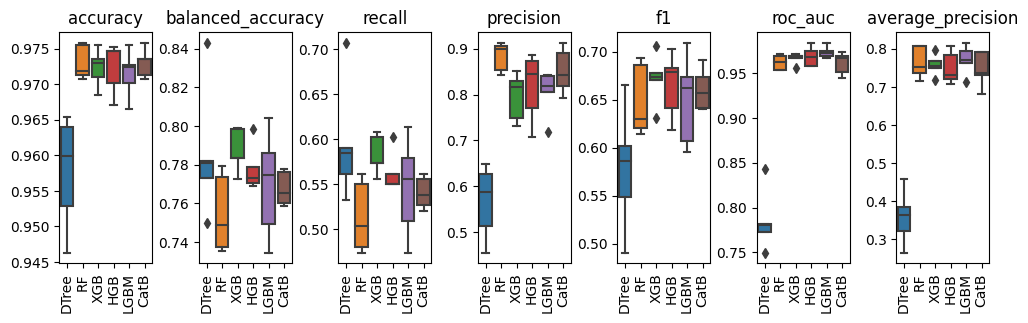

In [23]:
# Plot each scoring metric grouped by model
metrics = cv_results.filter(like='test').columns

fig, axs = plt.subplots(figsize=(12,3), ncols=len(metrics))
plt.subplots_adjust(wspace=0.5)

for axis, metric in enumerate(metrics):
    sns.boxplot(data=cv_results, x='model_name', y=metric, ax=axs[axis])
    axs[axis].set(title=metric.replace('test_', ''), ylabel='', xlabel='')
    axs[axis].set_xticklabels(['DTree', 'RF', 'XGB', 'HGB', 'LGBM', 'CatB'], rotation=90)

In order to evaluate the models based on this visualization, we'll look at the distribution of the 5 cv splits. More precisely, we look at the variability of the data, mean, median and the interquartile range.

Based on this, 3 models stick out:
- Random Forest with best performance in terms of accuracy, precision and PR-AUC (i.e. average precision)
- XGBoost with best performance in balanced accuracy, recall and F1 score
- LightGBM for best performance in terms of ROC-AUC

In [24]:
# Let's confirm this by looking at the mean values
mean_results = cv_results.drop('run', axis=1).groupby(by='model_name', sort=False).mean()
# rename index and transpose dataframe
mean_results_T = mean_results.rename(index={'Histogram-based Gradient Boosting': 'HGB'}).T
# add index of maximum in column
pd.concat([mean_results_T, mean_results.idxmax(0)], axis=1).rename(columns={0:'Classifier with Max Value'})

,DecisionTree,Random Forest,XGBoost,HGB,LightGBM,CatBoost,Classifier with Max Value
fit_time,0.163846,2.867917,0.687697,2.081952,1.409133,30.864305,CatBoost
score_time,0.028268,0.232926,0.106869,0.224120,0.092272,0.061180,Random Forest
test_accuracy,0.957666,0.973065,0.972327,0.972383,0.971474,0.973008,Random Forest
test_balanced_accuracy,0.785746,0.754993,0.787346,0.777942,0.769695,0.767727,XGBoost
test_recall,0.595322,0.513450,0.582456,0.562573,0.546199,0.540351,DecisionTree
test_precision,0.566303,0.883117,0.795477,0.816208,0.805320,0.851370,Random Forest
test_f1,0.578541,0.648846,0.671883,0.665021,0.649516,0.660621,XGBoost
test_roc_auc,0.785746,0.961768,0.966251,0.968329,0.973317,0.961036,LightGBM
test_average_precision,0.359007,0.763369,0.757382,0.750082,0.770989,0.746316,LightGBM


In [25]:
# have a closer look at the 3 models mentioned earlier, i.e. Random Forest, XGBoost, and LightGBM
mean_results.drop(['fit_time', 'score_time'], axis=1).loc[['Random Forest', 'XGBoost', 'LightGBM']].T

model_name,Random Forest,XGBoost,LightGBM
test_accuracy,0.973065,0.972327,0.971474
test_balanced_accuracy,0.754993,0.787346,0.769695
test_recall,0.513450,0.582456,0.546199
test_precision,0.883117,0.795477,0.805320
test_f1,0.648846,0.671883,0.649516
test_roc_auc,0.961768,0.966251,0.973317
test_average_precision,0.763369,0.757382,0.770989


Our sample contains 95.14% of class 0, i.e. non-fraudulent/real, jobs. Dealing with this class imbalance, we'll have to refrain of simply looking at the accuracy metric (A naive estimator predicting only 0 would be right 95.14% of the time). 

Rather, we should be paying attention to precision (the share of positive predictions that were actually correct) and recall (the share of real positives that were identified as such). In addition, metrics that combine/weigh both (i.e. F1 and PR-AUC) can be taken into account.

In our case, precision would depict the share of correctly predicted fraudulent jobs over all predicted fraudulent jobs.
Recall on the other hand is the share of correctly predicted fraudulent jobs over all actual fraudulent jobs.

We have to weigh the cost of these 2 metrics by thinking about their implications. Having a weak precision would lead to classifying real job postings as fraudulent, and therefore missing out the chance to apply for a good position. On the other hand, with insufficient recall, we might misclassify fraudulent jobs as real jobs and thereby risking being scammed.

In some situations, the cost of one metric might outweigh the cost of the other. In our case, both feel equally important.
Hence, we will pick a model that, while not necessarily provides the best score for one metric, does well when looking at both metrics.

For this, we will mainly look at the F1-Score, as this harmonizes the accuracy and precision score.

Thus, the winner is... **XGBoost**!

### XGBoost

In [26]:
# Train Model
xgbc = XGBClassifier(random_state=42)
#xgbc.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)])
xgbc.fit(X_train, y_train);

### Model Evaluation

In [27]:
# Predict class and probabilities
y_predict = xgbc.predict(X_test)
y_score = pd.DataFrame(xgbc.predict_proba(X_test))[1]

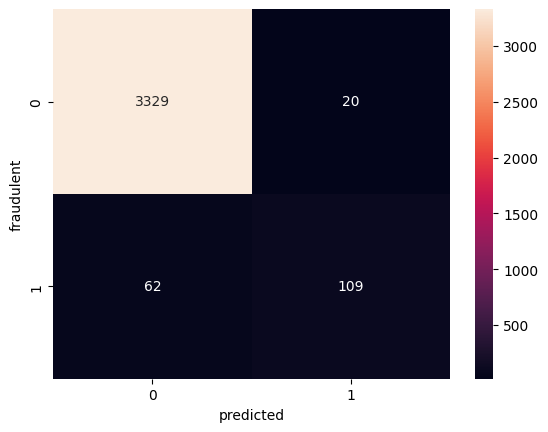

In [28]:
# Display confusion matrix
sns.heatmap(pd.crosstab(y_test, y_predict), annot=True, fmt='d').set_xlabel('predicted');

In [29]:
# store and print evaluation metrics
model_evaluation_metrics = pd.Series({
    'Accuracy': accuracy_score(y_true=y_test, y_pred=y_predict),
    'Balanced Accuracy': balanced_accuracy_score(y_true=y_test, y_pred=y_predict),
    'Recall': recall_score(y_true=y_test, y_pred=y_predict),
    'Precision': precision_score(y_true=y_test, y_pred=y_predict),
    'F1-Score': f1_score(y_true=y_test, y_pred=y_predict),
    'ROC-AUC': roc_auc_score(y_true=y_test, y_score=y_score),
    'PR-AUC': average_precision_score(y_true=y_test, y_score=y_score)
})
model_evaluation_metrics.round(4)

Accuracy             0.9767
Balanced Accuracy    0.8157
Recall               0.6374
Precision            0.8450
F1-Score             0.7267
ROC-AUC              0.9792
PR-AUC               0.8121
dtype: float64

### Feature Importance

In [30]:
# store feature importance
xgbc_feature_importance = pd.DataFrame({'feature_name': xgbc.feature_names_in_,
                                        'feature_importance': xgbc.feature_importances_})
# sort descending
xgbc_feature_importance = xgbc_feature_importance.sort_values(by='feature_importance', ascending=False)
# show top 5
xgbc_feature_importance.head(5)

,feature_name,feature_importance
1,has_company_logo,0.083669
7,location_country_US,0.071516
3,company_profile_length,0.069276
24,required_experience_Entry level,0.064314
30,required_education_Bachelor's Degree,0.052442


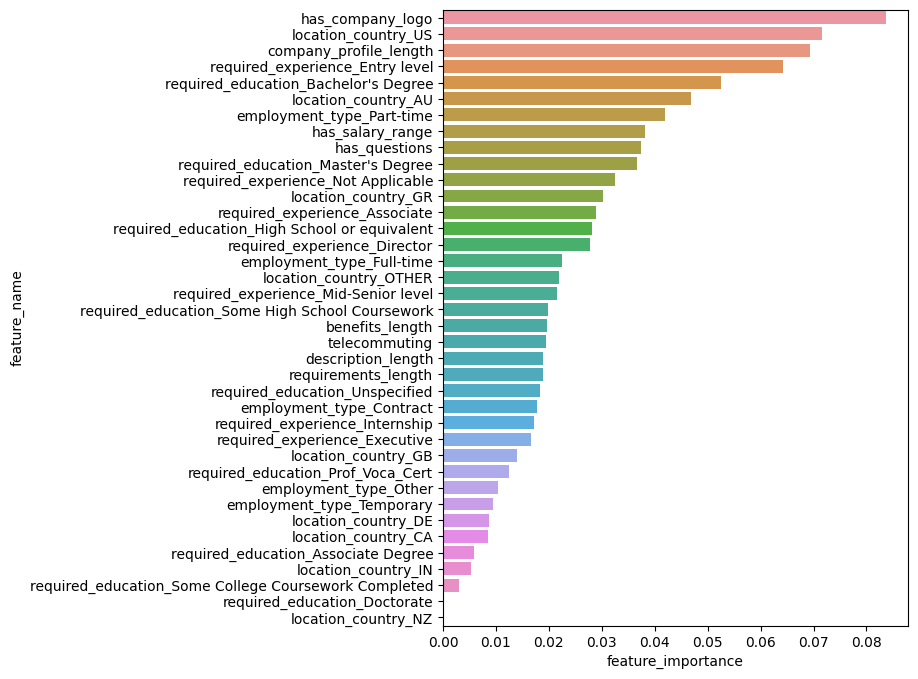

In [31]:
# Plot feature importances
plt.figure(figsize=(6, 8))
sns.barplot(data=xgbc_feature_importance, x='feature_importance', y='feature_name');

### Shapley Values

In [32]:
explainer = shap.TreeExplainer(xgbc.fit(X, y))
shap_values = explainer(X)

In [33]:
xgbc_shap_values = pd.DataFrame(list(zip(X.columns, np.abs(shap_values.values).mean(0))),
                                columns=['feature_name','feature_importance'])
xgbc_shap_values['feature_importance_%'] = (xgbc_shap_values['feature_importance'] /
                                            xgbc_shap_values['feature_importance'].sum())
xgbc_shap_values.sort_values(by='feature_importance',
                             ascending=False, inplace=True)
xgbc_shap_values.head()

,feature_name,feature_importance,feature_importance_%
3,company_profile_length,2.104038,0.307738
7,location_country_US,0.662333,0.096873
5,requirements_length,0.473224,0.069214
1,has_company_logo,0.424305,0.062059
6,benefits_length,0.406492,0.059454


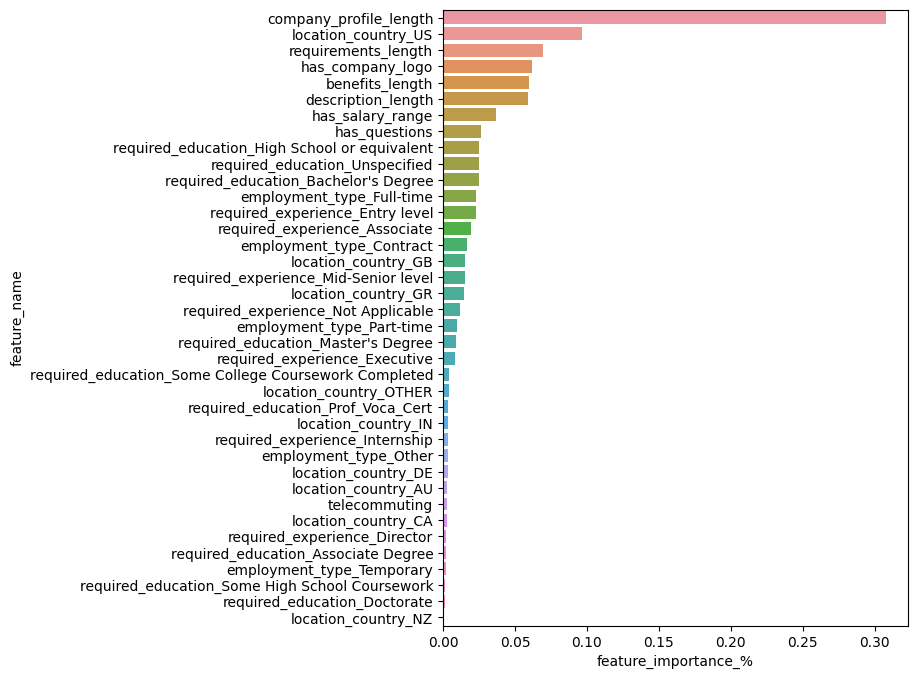

In [34]:
# Plot Shapley Values
plt.figure(figsize=(6, 8))
sns.barplot(data=xgbc_shap_values, x='feature_importance_%', y='feature_name');

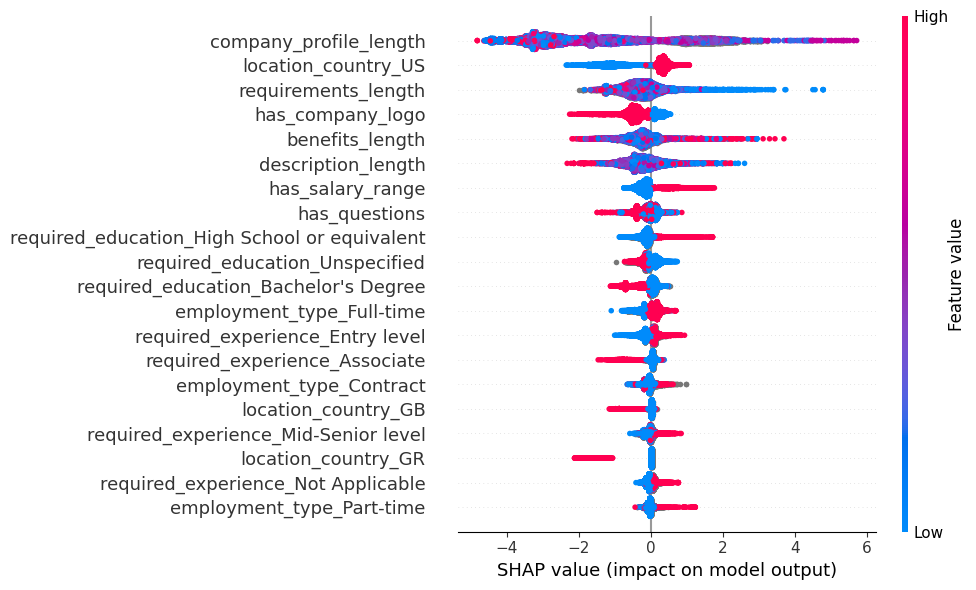

In [35]:
# Beeswarm plot
shap.summary_plot(shap_values, X, plot_size=(10,6))

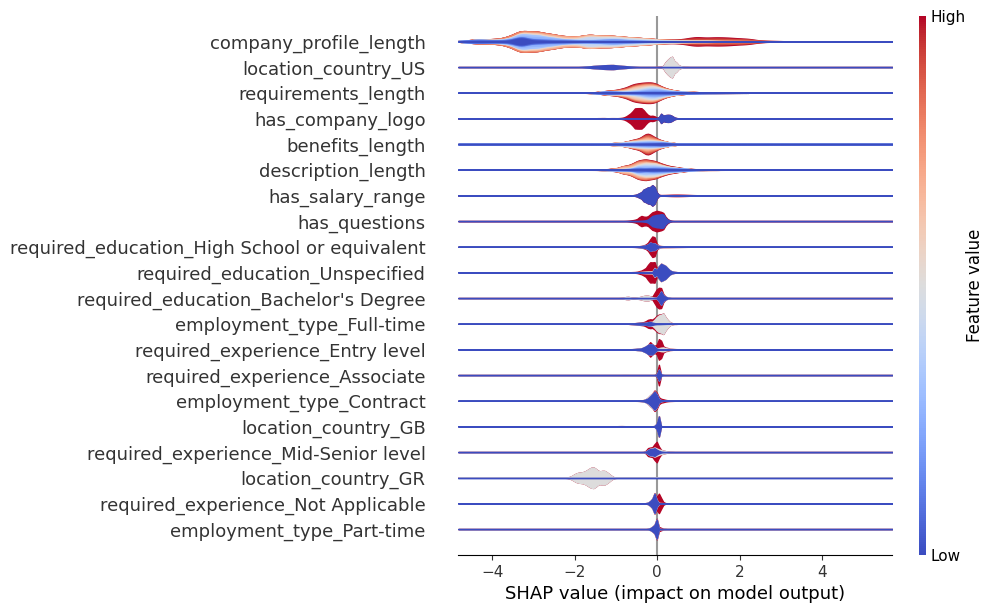

In [36]:
shap.plots.violin(shap_values, plot_type='layered_violin', plot_size=(7,7))

## Predicting Fraudulent Jobs Based on Written Job Description

In [37]:
# Transform job posting text into TF-IDF vector
vectorizer = TfidfVectorizer(lowercase=False, stop_words='english')

tfidf_X = vectorizer.fit_transform(df['job_posting'])
tfidf_y = df['fraudulent']

In [38]:
# print shape of TF-IDF vector 
print('tfidf_X shape: ', tfidf_X.shape)

tfidf_X shape:  (17598, 118737)


### Model Selection

In [39]:
# Define classifier models and store in dictionary
gbc = GradientBoostingClassifier(random_state=42)
svc = LinearSVC(fit_intercept=True, random_state=42)
mnbc = MultinomialNB()
knn = KNeighborsClassifier()
lreg = LogisticRegression(fit_intercept=True, random_state=42)
dtc = DecisionTreeClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42)
xgbc = XGBClassifier(random_state=42)
gbmc = lgb.LGBMClassifier(random_state=42, verbose=-1)
# hgbc = HistGradientBoostingClassifier(random_state=42)  # -> does not support sparse matrices, dense format too large
# cbc = CatBoostClassifier(random_state=42, verbose=0)  # -> not suitable for analysis & incredibly slow

models = {'Gradient Boosting': gbc,
          'Support Vector': svc,
          'Naive Bayes': mnbc,
          'k Nearest Neighbour': knn,
          'Logistic Regression': lreg,
          'DecisionTree': dtc,
          'Random Forest': rfc,
          'XGBoost': xgbc,
          'LightGBM': gbmc}

In [40]:
# Define metrics to be evaluated and splitting strategy
scoring = ['accuracy', 'balanced_accuracy', 'recall', 'precision', 'f1', 'roc_auc', 'average_precision']
k_fold = 5

In [41]:
####### UNCOMMENT TO RE-RUN CROSS-VALIDATION (20-30 minutes)
#
# # Run cross-validation with 5-fold split for each model
# tfidf_cv_scores = {key: [] for key in models.keys()}
# for model_name, model in models.items():
#     print(f'Executing {model_name}...')
#     tfidf_cv_scores[model_name] = cross_validate(model, tfidf_X, tfidf_y, cv=k_fold, scoring=scoring, n_jobs=-1, verbose=10)
#
#######

####### UNCOMMENT TO STORE RESULTS OF CROSS-VALIDATION
#
# # In order to skip rerunning the cross-validation, store results in pickle file
# with open('tfidf_cv_scores.pkl', 'wb') as f:
#     pickle.dump(tfidf_cv_scores, f)
# 
#######

In [42]:
# Open stored cross-validation results
try:
    with open('tfidf_cv_scores.pkl', 'rb') as f:
        tfidf_cv_scores = pickle.load(f)
except FileNotFoundError:
    print('Run Cross-Validation from previous cell first')

In [43]:
# store results score wise for all models and for all cross-validation runs
tfidf_cv_scores_long = {key: [] for key in tfidf_cv_scores[list(tfidf_cv_scores.keys())[0]]}
model_names = []

for model_name, model_results in tfidf_cv_scores.items():
    model_names.extend([model_name]*k_fold)
    for score, score_results in model_results.items():
        tfidf_cv_scores_long[score].extend(score_results)

In [44]:
# show keys
tfidf_cv_scores_long.keys()

dict_keys(['fit_time', 'score_time', 'test_accuracy', 'test_balanced_accuracy', 'test_recall', 'test_precision', 'test_f1', 'test_roc_auc', 'test_average_precision'])

In [45]:
# store results in a dataframe with columns for model_name and run id.
tfidf_cv_results = pd.concat([pd.Series(model_names).rename('model_name'),
                         pd.Series([n for n in range(k_fold)]*len(models)).rename('run'),
                         pd.DataFrame(tfidf_cv_scores_long)], axis=1)
tfidf_cv_results.head(7)

,model_name,run,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_recall,test_precision,test_f1,test_roc_auc,test_average_precision
0,Gradient Boosting,0,590.372874,0.109580,0.978409,0.786102,0.573099,0.970297,0.720588,0.905103,0.748977
1,Gradient Boosting,1,587.932153,0.147009,0.973011,0.744420,0.491228,0.913043,0.638783,0.920164,0.729054
2,Gradient Boosting,2,598.232639,0.266480,0.976989,0.771482,0.543860,0.968750,0.696629,0.936021,0.817296
3,Gradient Boosting,3,601.259227,0.087407,0.971867,0.721625,0.444444,0.950000,0.605578,0.900199,0.692506
4,Gradient Boosting,4,603.254496,0.063389,0.972151,0.743971,0.491228,0.884211,0.631579,0.912215,0.665189
5,Support Vector,0,0.942467,0.065613,0.986648,0.870897,0.742690,0.976923,0.843854,0.977516,0.897942
6,Support Vector,1,0.911214,0.078124,0.980966,0.817967,0.637427,0.956140,0.764912,0.981180,0.870810


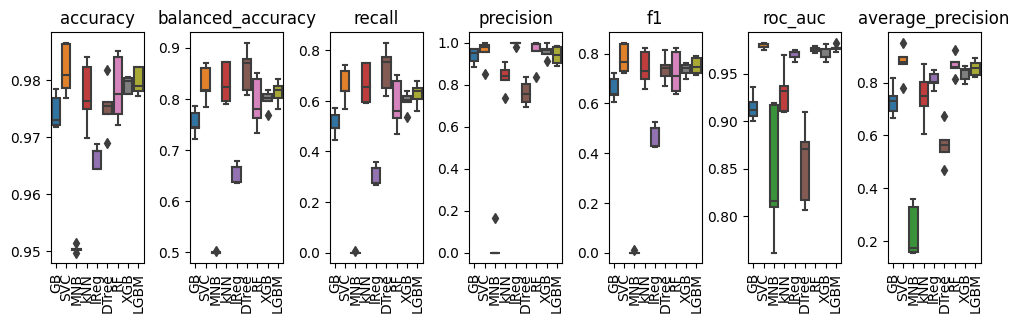

In [46]:
# Plot each scoring metric grouped by model
metrics = tfidf_cv_results.filter(like='test').columns

fig, axs = plt.subplots(figsize=(12,3), ncols=len(metrics))
plt.subplots_adjust(wspace=0.5)

for axis, metric in enumerate(metrics):
    sns.boxplot(data=tfidf_cv_results, x='model_name', y=metric, ax=axs[axis])
    axs[axis].set(title=metric.replace('test_', ''), ylabel='', xlabel='')
    axs[axis].set_xticklabels(['GB', 'SVC', 'MNB', 'kNN', 'lReg', 'DTree', 'RF', 'XGB', 'LGBM'], rotation=90)

Again, a few models stick out:
- The SupportVectorClassifier for great accuracy, F1-score and PR-AUC
- Decision Tree for balanced accuracy and recall
- Logistic Regression for precision

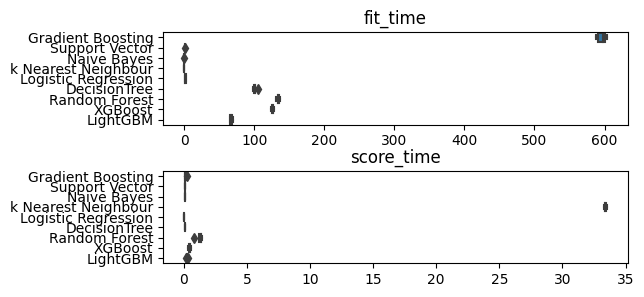

In [47]:
# Plot timing performance
fig, axs = plt.subplots(figsize=(6,3), nrows=2)
plt.subplots_adjust(hspace=0.5)

for axis, metric in enumerate(['fit_time', 'score_time']):
    sns.boxplot(data=tfidf_cv_results, y='model_name', x=metric, ax=axs[axis])
    axs[axis].set(title=metric.replace('test_', ''), ylabel='', xlabel='')

In [48]:
# Let's look at the mean values over all folds
tfidf_mean_results = tfidf_cv_results.drop('run', axis=1).groupby(by='model_name', sort=False).mean()
# add index of maximum in column
tfidf_mean_results = pd.concat([tfidf_mean_results.T, tfidf_mean_results.idxmax(0)], axis=1)
tfidf_mean_results = tfidf_mean_results.rename(columns={0:'Classifier with Max Value'})
tfidf_mean_results.round(4)

,Gradient Boosting,Support Vector,Naive Bayes,k Nearest Neighbour,Logistic Regression,DecisionTree,Random Forest,XGBoost,LightGBM,Classifier with Max Value
fit_time,596.2103,0.9358,0.2197,0.0546,1.5169,101.3352,134.4202,126.6517,67.4261,Gradient Boosting
score_time,0.1348,0.0899,0.1074,33.3893,0.0405,0.0803,1.2463,0.4669,0.2554,k Nearest Neighbour
test_accuracy,0.9745,0.9819,0.9504,0.9776,0.9666,0.9753,0.9786,0.9792,0.9798,Support Vector
test_balanced_accuracy,0.7535,0.8296,0.5000,0.8306,0.6567,0.8566,0.7934,0.7987,0.8124,DecisionTree
test_recall,0.5088,0.6608,0.0012,0.6678,0.3135,0.7251,0.5883,0.5988,0.6269,DecisionTree
test_precision,0.9373,0.9549,0.0333,0.8365,0.9958,0.7605,0.9556,0.9588,0.9389,Logistic Regression
test_f1,0.6586,0.7792,0.0023,0.7419,0.4758,0.7392,0.7247,0.7362,0.7507,Support Vector
test_roc_auc,0.9147,0.9788,0.8448,0.9318,0.9698,0.8566,0.9753,0.9706,0.9770,Support Vector
test_average_precision,0.7306,0.8763,0.2349,0.7481,0.8101,0.5647,0.8662,0.8346,0.8557,Support Vector


In [49]:
# Have a closer look at SVC, Decision Tree, and Logistic Regression
tfidf_mean_results.loc['test_accuracy':, ['Support Vector', 'DecisionTree', 'Logistic Regression', 'Classifier with Max Value']]

,Support Vector,DecisionTree,Logistic Regression,Classifier with Max Value
test_accuracy,0.981929,0.975338,0.966587,Support Vector
test_balanced_accuracy,0.829573,0.856630,0.656695,DecisionTree
test_recall,0.660819,0.725146,0.313450,DecisionTree
test_precision,0.954884,0.760487,0.995833,Logistic Regression
test_f1,0.779157,0.739249,0.475810,Support Vector
test_roc_auc,0.978780,0.856630,0.969849,Support Vector
test_average_precision,0.876284,0.564712,0.810085,Support Vector


**Evaluation of the Models:**

Again, we aim to find a model that performs well in both recall and precision.

Logistic Regression, while having an almost perfect precision, underperforms in terms of recall.

The Decision Tree model shows the best performance for recall, but lacks precision compared to the other two models.

Finally, the Support Vector Classifier performs weaker on recall compared to Decision Tree, and slightly weaker with respect to precision than the Logistic Regression. However, it beats both models with regards to the harmonized performance metrics (F1 and PR-AUC - the area under the recall-precision-curve, or: average precision).

With the same rationale than before, the model for our final analysis chosen is: **Linear Support Vector Classification**!

### Linear SVC

In [50]:
# Define X and y
X = df['job_posting']
y = df['fraudulent']

# Split data into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Perform TF-IDF vectorization
vectorizer = TfidfVectorizer(lowercase=False, stop_words='english')
tfidf_X_train = vectorizer.fit_transform(X_train)
tfidf_X_test = vectorizer.transform(X_test)

In [51]:
# print distribution
print('tfidf_X_train shape:', tfidf_X_train.shape)
print('tfidf_X_test shape: ', tfidf_X_test.shape)
print(f'y_train shape: {y_train.shape}, fraudulent jobs: {sum(y_train)} ({round(sum(y_train)/len(y_train)*100, 2)}%)')
print(f'y_test shape:  {y_test.shape},  fraudulent jobs: {sum(y_test)} ({round(sum(y_test)/len(y_test)*100, 2)}%)')

tfidf_X_train shape: (14078, 105579)
tfidf_X_test shape:  (3520, 105579)
y_train shape: (14078,), fraudulent jobs: 684 (4.86%)
y_test shape:  (3520,),  fraudulent jobs: 171 (4.86%)


In [52]:
# Train model
svc = LinearSVC(fit_intercept=True, dual='auto', random_state=42)
svc.fit(tfidf_X_train, y_train);

### Model Evaluation

In [53]:
# Predict classes
svc_y_predict = svc.predict(tfidf_X_test)

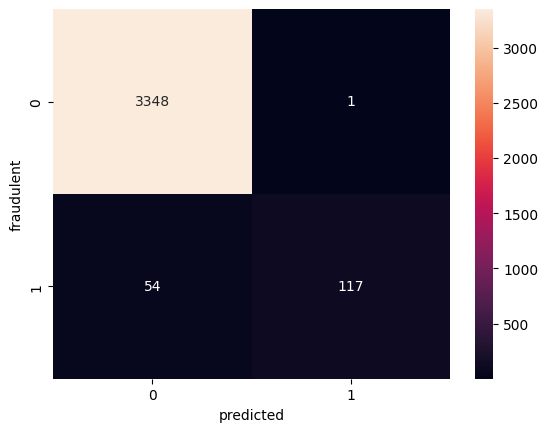

In [54]:
# Display confusion matrix
sns.heatmap(pd.crosstab(y_test, svc_y_predict), annot=True, fmt='d').set_xlabel('predicted');

In [55]:
# store and print evaluation metrics
svc_evaluation_metrics = pd.Series({
    'Accuracy': accuracy_score(y_true=y_test, y_pred=svc_y_predict),
    'Balanced Accuracy': balanced_accuracy_score(y_true=y_test, y_pred=svc_y_predict),
    'Recall': recall_score(y_true=y_test, y_pred=svc_y_predict),
    'Precision': precision_score(y_true=y_test, y_pred=svc_y_predict),
    'F1-Score': f1_score(y_true=y_test, y_pred=svc_y_predict)
})
svc_evaluation_metrics.round(4)

Accuracy             0.9844
Balanced Accuracy    0.8420
Recall               0.6842
Precision            0.9915
F1-Score             0.8097
dtype: float64

### Feature Importance

Support Vector Machines do not provide integrated feature importance methods. SHAP's KernelExplainer would require predicted probability scores returned from our model which only the SVC(kernel="linear", probability=True) configuration could achieve. However, this process is incredibly computationally intensive and not in the scope of this project.

Alternatively, we are going to inspect the model's coefficients. These are utilized to predict the class of new data by determining the side of the hyperplane this datapoint will end up. More precisely, calculating the decision function by taking the sum of intercept and the product of the TF-IDF vector (X) and the coefficients, we'll arrive at one score for each case. Based on this, the cases will be predicted to be in class 0 (score < 0) or class 1 (score > 0). Arguably, as we have only positive TF-IDF values for the independent variables, the sign of a coefficient has some part in determining the predicted class.

Hence, we'll look at the top positive and negative coefficients to determine some of the most relevant features.

In [56]:
# store feature coefficients
svc_coefficients = pd.DataFrame({'feature_name': vectorizer.get_feature_names_out(),
                                 'coefficient': svc.coef_[0]})

# pick top x negative and positive coefficients
top_x = 30
svc_coefficients_top_x = svc_coefficients.sort_values(by='coefficient', ascending=False).head(30)
svc_coefficients_top_x = pd.concat([svc_coefficients_top_x, svc_coefficients.sort_values(by='coefficient').head(30)])

svc_coefficients_top_x.sample(6)

,feature_name,coefficient
78030,passionate,-0.613821
2697,Accion,2.047396
12676,Employee,0.969963
87712,right,-0.645121
30543,Rohan,1.547654
3394,Allied,-0.806476


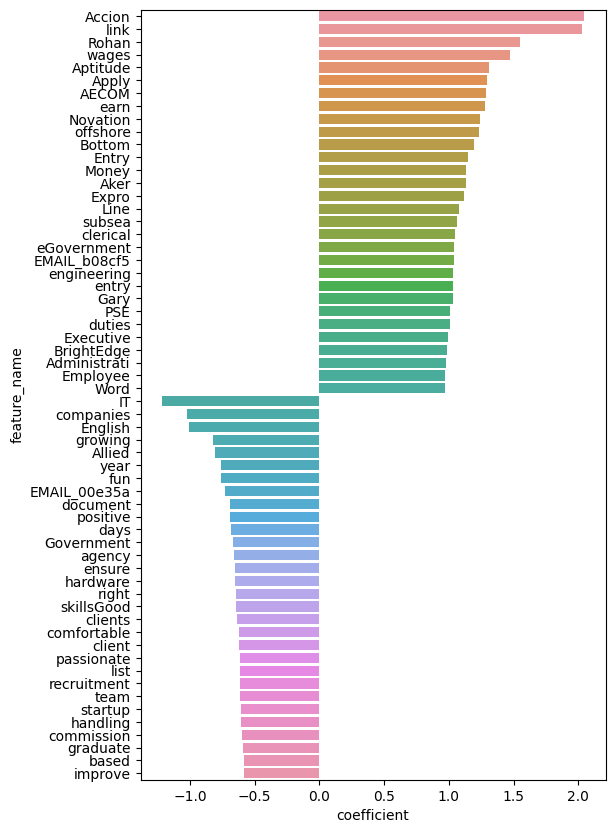

In [57]:
# Plot feature importances
plt.figure(figsize=(6, 10))
coef_plot = sns.barplot(data=svc_coefficients_top_x, x='coefficient', y='feature_name')

# slice feature names and add as y-tick labels 
feature_name_short = svc_coefficients_top_x['feature_name'].str.slice(0,12)
coef_plot.set_yticklabels(feature_name_short);

**Feature Importance Interpretation**

Noticeable, on the **positive** side - and thus adding the potential prediction of a job posting as fraudulent - we find many feature names that can be associated with **company names**, such as 'Accion', 'Aptitude', 'AECOM'. As can be seen below, these company names frequently appear in fraudulent job postings. The term **'link'** scores second amongst the feature, which could imply that fraudulent jobs particularly stress to follow links in order to apply, compared to offering applying on the job board the job is posted on. Additionally, we see the terms 'wages', 'Money' and 'earn' appear in the top list of positive coefficients. This could mean that fraudulent job postings focus more strongly on the **monetary aspect** compared to non-fraudulent jobs. Finally, some descriptive terms such as 'Entry' and 'duties' stick out, pointing at job postings that are tailored to more **inexperienced applicants**.

On the **negative** side, the term 'IT' has the largest coefficient. It is interesting to see how many **positive words** we find, such as 'growing', 'fun', 'positive', 'ensure', 'right', 'comfortable', 'passionate', and 'improve'. Also, the terms 'agency', 'client(s)', 'team', and 'startup' show that real job postings might be more descriptive in terms of the **working environment**.

In [58]:
# Define a few companies listed above
companies = ['Accion', 'Rohan', 'Aptitude', 'AECOM', 'Novation', 'Aker', 'Expro', 'PSE']

# For each, count total number of occurance in dataset and number of fraudulent jobs
print('Company Name   Total n    Fraud n')
for comp in companies:
    has_comp = df['description'].str.contains(comp)
    comp_count = has_comp.sum()
    is_fraud = np.where((has_comp) & (df['fraudulent']), 1, 0)
    fraud_count = is_fraud.sum()
    print(f'{comp:<15}{comp_count:<11}{fraud_count}')

Company Name   Total n    Fraud n
Accion         1          1
Rohan          3          3
Aptitude       3          1
AECOM          7          7
Novation       4          4
Aker           51         51
Expro          11         11
PSE            6          3


In [59]:
# Print columns for company name 'PSE'
df.loc[df['description'].str.contains('PSE'), ['title', 'location', 'description', 'fraudulent']]

,title,location,description,fraudulent
3044,Senior Local Government Affairs Representative,"US, ,",At Puget SoundEnergy (PSE) we have a long trad...,1
3490,Senior Engineer,"US, ,",Apply using below link#URL_1eead1e24bbaa4318cc...,1
4284,Sales Advisor (Energy),"GB, GLG, Glasgow",ROLE: OUTBOUND SALES - UPSELLING TO EXISTING C...,0
7191,QA Manager,"US, NY, New York",We're looking for an experienced QA Manager wi...,0
7370,Senior Local Government Affairs Representative,US,Apply using below link#URL_ea54d715858cb6aef8d...,1
8691,Senior Windows/Vmware Administrator,"US, WA, Bellevue",Position : Senior Windows AdministratorJob Lo...,0
